# ICT4SM GOUP 14 LAB 2

In [4]:
import pymongo as pm 
from pymongo import MongoClient
import pprint 
import datetime
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from datetime import timedelta

from sklearn.neighbors import KernelDensity
import numpy as np


client = pm.MongoClient('bigdatadb.polito.it:27017',
                        ssl=True,
                        authSource = 'carsharing',
                        username = 'ictts',
                        password ='Ict4SM22!',
                        tlsAllowInvalidCertificates=True)



db_car2go = client["carsharing"]["ictts_PermanentBookings"]
db_enjoy = client["carsharing"]["ictts_enjoy_PermanentBookings"]



## Tasks

### 1 For carsharing data, check if the booking records requires to be filtered to get valid rentals. Derive the OD matrix based on the zones of Torino

Filtering function

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Progress bar
from datetime import datetime

# Load zones from GeoJSON file
zones = gpd.read_file("./Zone/TorinoZonescol.geojson").to_crs("EPSG:4326")

# Fetch data in small batches with progress tracking
def fetch_all_data_in_batches(collection, collection_name, batch_size=10000):
    cursor = collection.find({}, {"init_loc": 1, "final_loc": 1, "init_time": 1}, no_cursor_timeout=True)
    with tqdm(desc=f"Fetching {collection_name} data", unit="records") as pbar:
        try:
            batch_data = []
            for document in cursor:
                batch_data.append(document)
                pbar.update(1)
                if len(batch_data) >= batch_size:
                    yield pd.DataFrame(batch_data)
                    batch_data = []
            if batch_data:
                yield pd.DataFrame(batch_data)
        finally:
            cursor.close()

# Filter valid rentals (init_loc and final_loc must be distinct)
def filter_valid_rentals(df):
    return df[df["init_loc"] != df["final_loc"]]

# Assign zones to trips
def assign_zones(df, zones):
    if "zone_id" not in zones.columns:
        zones["zone_id"] = range(len(zones))

    df["ORI_ZONE"] = gpd.sjoin(
        gpd.GeoDataFrame(df, geometry=df["init_loc"].apply(lambda loc: Point(*loc['coordinates'])), crs="EPSG:4326"),
        zones, how="left", predicate="intersects"
    )["zone_id"]

    df["DST_ZONE"] = gpd.sjoin(
        gpd.GeoDataFrame(df, geometry=df["final_loc"].apply(lambda loc: Point(*loc['coordinates'])), crs="EPSG:4326"),
        zones, how="left", predicate="intersects"
    )["zone_id"]

    return df.dropna(subset=["ORI_ZONE", "DST_ZONE"]).reset_index(drop=True)

# Add hour, day, and date columns based on init_time
def add_time_columns(df):
    df["hour"] = pd.to_datetime(df["init_time"], unit="s").dt.hour
    df["day"] = pd.to_datetime(df["init_time"], unit="s").dt.weekday
    df["date"] = pd.to_datetime(df["init_time"], unit="s").dt.date  # Adding date column
    return df

# Normalize OD matrix
def normalize_od_matrix_bidirectional(df):
    pivot = df.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="count", fill_value=0)

    for _ in range(10):
        # Normalize rows
        row_sums = pivot.sum(axis=1)
        pivot = pivot.div(row_sums, axis=0).fillna(0)

        # Normalize columns
        col_sums = pivot.sum(axis=0)
        pivot = pivot.div(col_sums, axis=1).fillna(0)

    return pivot.stack().reset_index(name="normalized_count")

# Generate OD matrix with bidirectional normalization
def generate_od_matrix_with_bidirectional_normalization(df, zones):
    df_with_zones = assign_zones(df, zones)
    df_with_zones = add_time_columns(df_with_zones)

    # Group by Origin, Destination, Hour, Day, and Date
    od_matrix = df_with_zones.groupby(["ORI_ZONE", "DST_ZONE", "hour", "day", "date"]).size().reset_index(name="count")
    normalized_matrix = normalize_od_matrix_bidirectional(od_matrix)
    normalized_matrix = pd.merge(normalized_matrix, od_matrix, on=["ORI_ZONE", "DST_ZONE"], how="left")
    return normalized_matrix

# Save OD matrix to CSV
def save_od_matrix_to_csv(od_matrix, filename):
    od_matrix.to_csv(filename, index=False)

# Process and save OD matrices for Car2GO and Enjoy
def process_and_save_matrices(db_collection, collection_name, zones, output_file):
    all_od_matrices = []
    for batch in fetch_all_data_in_batches(db_collection, collection_name):
        filtered_batch = filter_valid_rentals(batch)
        od_matrix = generate_od_matrix_with_bidirectional_normalization(filtered_batch, zones)
        all_od_matrices.append(od_matrix)

    final_od_matrix = pd.concat(all_od_matrices, ignore_index=True)
    save_od_matrix_to_csv(final_od_matrix, output_file)
    print(f"Saved {collection_name} OD matrix to {output_file}")

# Processing Car2GO and Enjoy data
print("Processing Car2GO data...")
process_and_save_matrices(db_car2go, "Car2GO", zones, "car2go_od_matrix.csv")

print("Processing Enjoy data...")
process_and_save_matrices(db_enjoy, "Enjoy", zones, "enjoy_od_matrix.csv")

print("Processing completed.")

### a. Compute OD matrices on different periods (weekdays vs weekends, daytime vs night-time). Is it possible to spot any difference? 

Plotting Car2GO OD matrices for different periods...


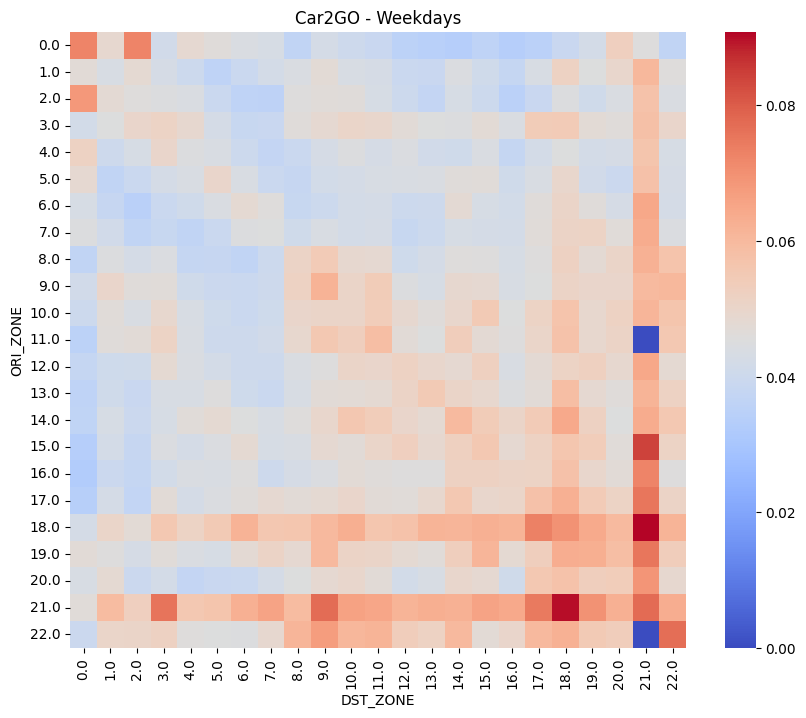

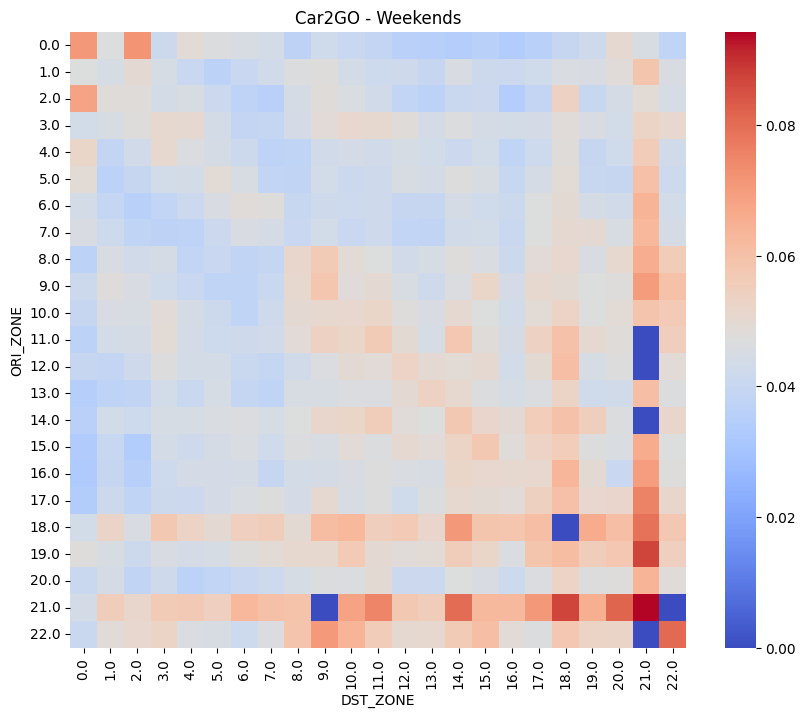

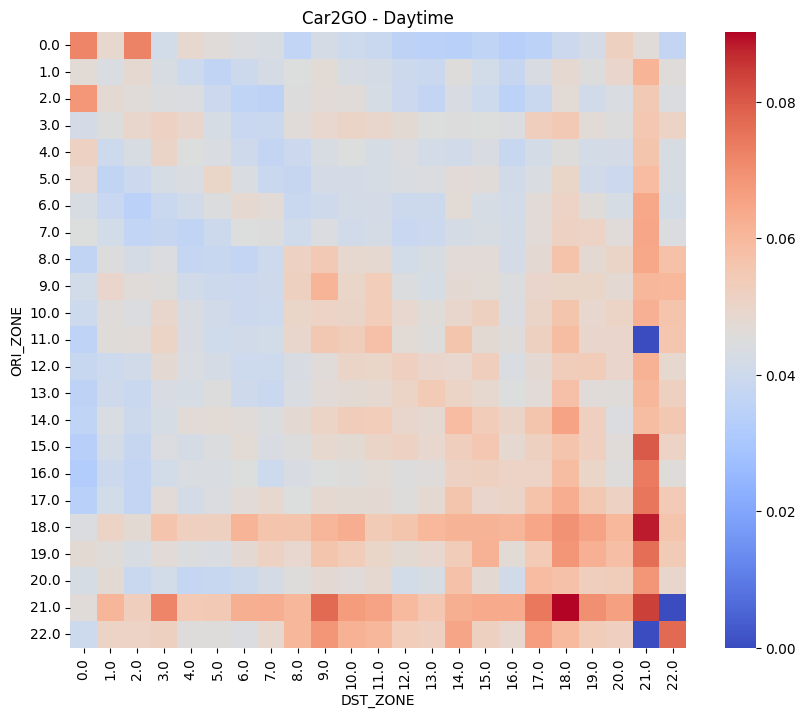

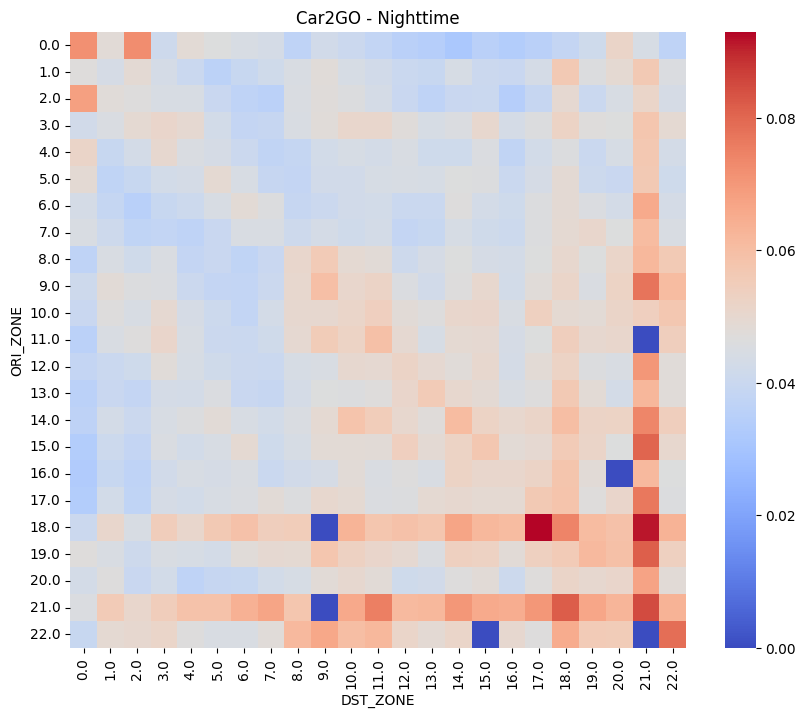

Plotting Car2GO OD matrices for same period diferent week


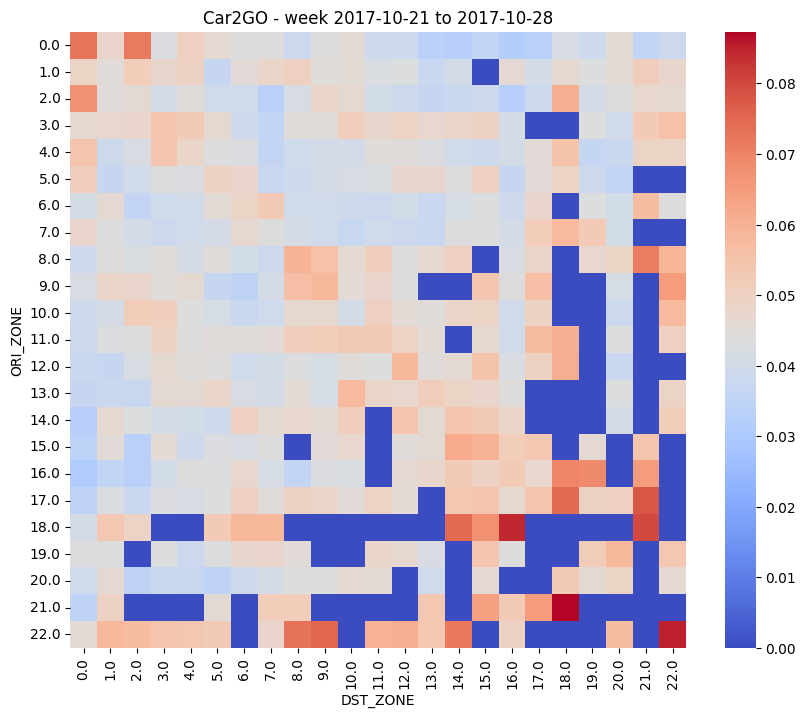

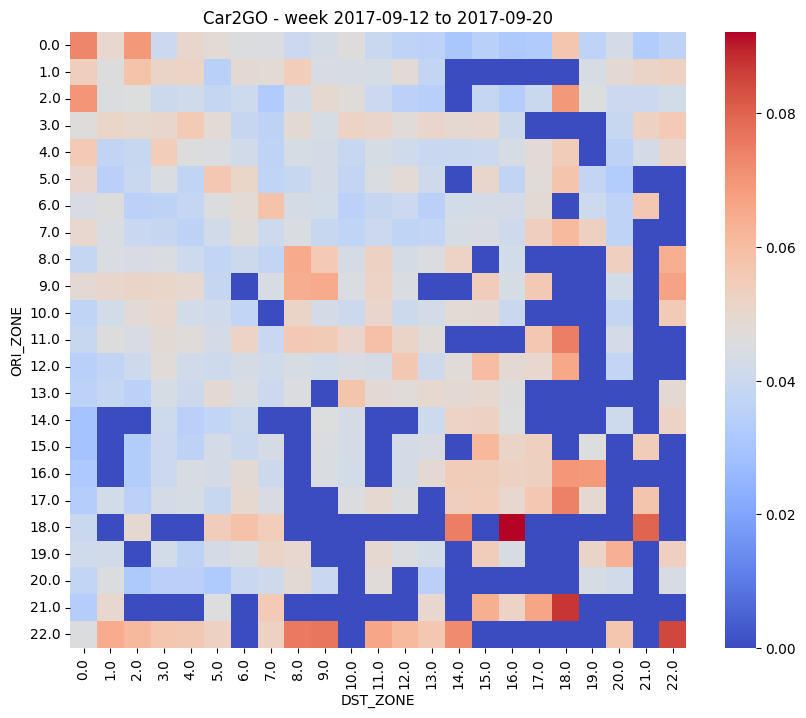

Plotting comparison between Car2GO and Enjoy...


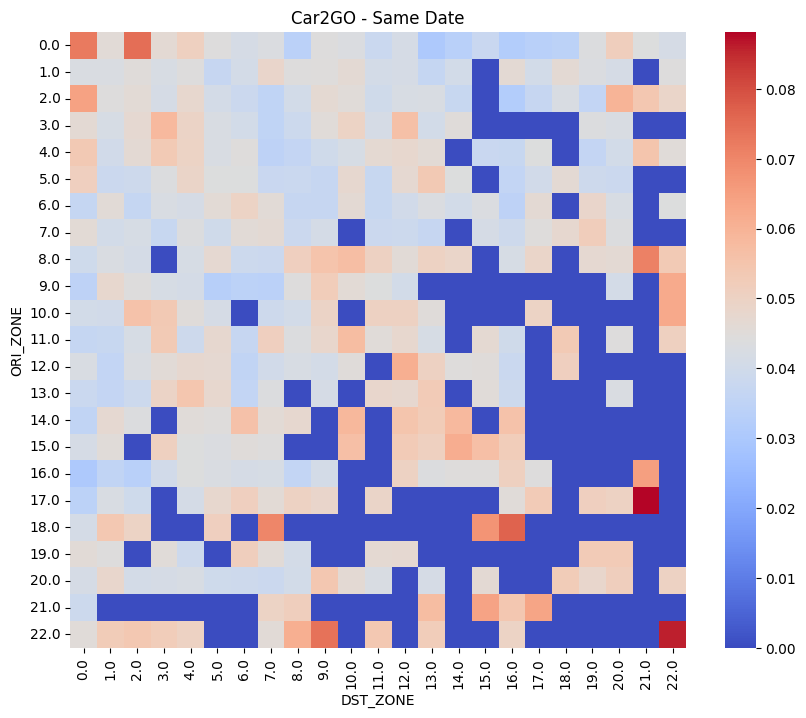

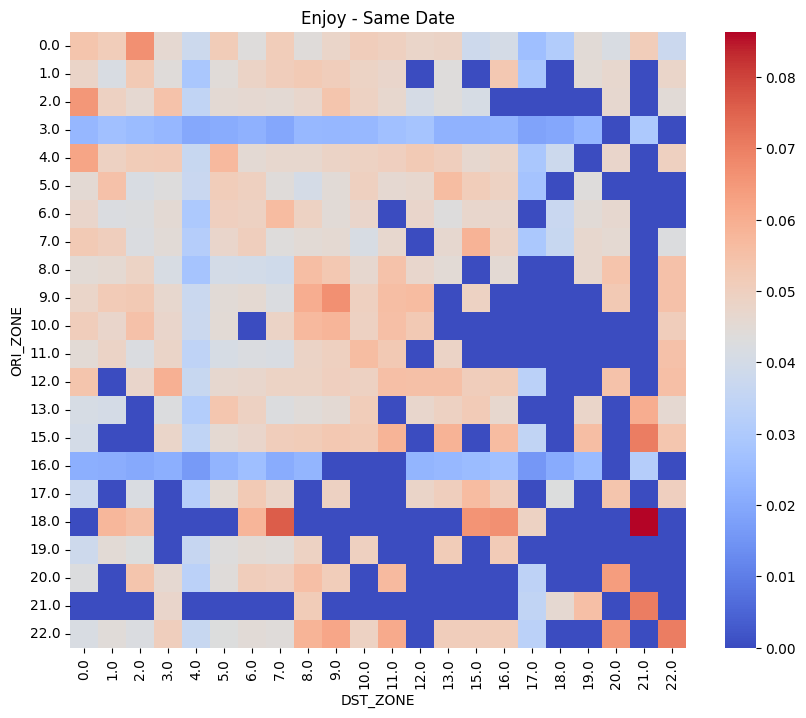

Processing and plotting completed.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

def filter_od_matrix(df, day_filter=None, hour_filter=None, date_filter=None):
    if day_filter is not None:
        df = df[df["day"].isin(day_filter)]
    if hour_filter is not None:
        if hour_filter[0] < hour_filter[1]:  # Normal case, e.g., 6:00 to 18:00
            df = df[(df["hour"] >= hour_filter[0]) & (df["hour"] < hour_filter[1])]
        else:  # Overnight case, e.g., 18:00 to 6:00
            df = df[(df["hour"] >= hour_filter[0]) | (df["hour"] < hour_filter[1])]
    if date_filter is not None:
        df = df[(pd.to_datetime(df["date"]).isin(pd.to_datetime(date_filter)))]
    return df

def plot_od_matrix(df, title):
    if df.empty:
        print(f"No data available for {title}. Skipping plot.")
        return

    pivot = df.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="normalized_count", fill_value=0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, cmap="coolwarm", square=True, cbar=True)
    plt.title(title)
    plt.xlabel("DST_ZONE")
    plt.ylabel("ORI_ZONE")
    plt.show()

# Load OD matrices
car2go_od_matrix = pd.read_csv("car2go_od_matrix.csv")
enjoy_od_matrix = pd.read_csv("enjoy_od_matrix.csv")

# A. Compute OD matrices for different periods (weekdays vs weekends, daytime vs nighttime)
print("Plotting Car2GO OD matrices for different periods...")
weekday_od = filter_od_matrix(car2go_od_matrix, day_filter=range(0, 5))
plot_od_matrix(weekday_od, "Car2GO - Weekdays")

weekend_od = filter_od_matrix(car2go_od_matrix, day_filter=[5, 6])
plot_od_matrix(weekend_od, "Car2GO - Weekends")

daytime_od = filter_od_matrix(car2go_od_matrix, hour_filter=(6, 18))
plot_od_matrix(daytime_od, "Car2GO - Daytime")

nighttime_od = filter_od_matrix(car2go_od_matrix, hour_filter=(18, 6))
plot_od_matrix(nighttime_od, "Car2GO - Nighttime")

# B. Compute OD matrices for same period (weekdays but different weeks)
print("Plotting Car2GO OD matrices for same period diferent week")
week1_dates = ['2017-10-21', '2017-10-28']
week2_dates = ['2017-10-13', '2017-10-21']
week1_od = filter_od_matrix(car2go_od_matrix, day_filter=[0, 5], date_filter=week1_dates)
week2_od = filter_od_matrix(car2go_od_matrix, day_filter=[0, 5], date_filter=week2_dates)

plot_od_matrix(week1_od, "Car2GO - week 2017-10-21 to 2017-10-28")
plot_od_matrix(week2_od, "Car2GO - week 2017-09-12 to 2017-09-20")

# C. Compare OD matrices for the same date between 
print("Plotting comparison between Car2GO and Enjoy...")
same_date = ['2017-10-28']
same_date_car2go = filter_od_matrix(car2go_od_matrix, date_filter=same_date)
same_date_enjoy = filter_od_matrix(enjoy_od_matrix, date_filter=same_date)

plot_od_matrix(same_date_car2go, "Car2GO - Same Date")
plot_od_matrix(same_date_enjoy, "Enjoy - Same Date")

print("Processing and plotting completed.")

### b. Consider the same period, compute OD matrices on different dates (e.g., OD matrices of weekdays in two different weeks). is it possible to spot any difference? How does the different compare with different periods? 

### c. Consider the same period, compute OD matrices on same date for Car2GO and Enjoy. Is there any difference between different platforms? How does it compare with previous ones? 

## 2. Derive metrics to compute the similarity between OD matrices.

In [68]:


# Compute similarity metrics
def compute_similarity_metrics(matrix_a, matrix_b):
    zones = sorted(set(matrix_a["ORI_ZONE"]).union(matrix_b["ORI_ZONE"]))
    combined_a = matrix_a.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="normalized_count", fill_value=0).reindex(index=zones, columns=zones, fill_value=0)
    combined_b = matrix_b.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="normalized_count", fill_value=0).reindex(index=zones, columns=zones, fill_value=0)

    a_flat = combined_a.values.flatten()
    b_flat = combined_b.values.flatten()

    absolute_difference = np.sum(np.abs(a_flat - b_flat))
    mse = np.mean((a_flat - b_flat) ** 2)
    rmse = np.sqrt(mse)

    return {
        "Absolute Difference": absolute_difference,
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse
    }

# Similarity between Weekdays and Weekends
similarity_weekday_weekend = compute_similarity_metrics(weekday_od, weekend_od)
print("Similarity between Weekdays and Weekends:")
for metric, value in similarity_weekday_weekend.items():
    print(f"  {metric}: {value:.4f}")

# Similarity between Daytime and Nighttime
similarity_daytime_nighttime = compute_similarity_metrics(daytime_od, nighttime_od)
print("Similarity between Daytime and Nighttime:")
for metric, value in similarity_daytime_nighttime.items():
    print(f"  {metric}: {value:.4f}")

# Similarity between Week 1 and Week 2
similarity_weeks = compute_similarity_metrics(week1_od, week2_od)
print("Similarity between Week 1 and Week 2:")
for metric, value in similarity_weeks.items():
    print(f"  {metric}: {value:.4f}")

# Similarity between Car2GO and Enjoy on the same date
similarity_car2go_enjoy = compute_similarity_metrics(same_date_car2go, same_date_enjoy)
print("Similarity between Car2GO and Enjoy on the same date:")
for metric, value in similarity_car2go_enjoy.items():
    print(f"  {metric}: {value:.4f}")

# Generate completely random matrices from the same CSV structure
random_matrix_1 = car2go_od_matrix.sample(frac=1).reset_index(drop=True)  # Shuffle Car2GO data
random_matrix_2 = enjoy_od_matrix.sample(frac=1).reset_index(drop=True)  # Shuffle Enjoy data

# Ensure random matrices have the required columns and normalize
random_matrix_1 = random_matrix_1.groupby(["ORI_ZONE", "DST_ZONE"]).size().reset_index(name="count")
random_matrix_1["normalized_count"] = random_matrix_1["count"] / random_matrix_1["count"].sum()

random_matrix_2 = random_matrix_2.groupby(["ORI_ZONE", "DST_ZONE"]).size().reset_index(name="count")
random_matrix_2["normalized_count"] = random_matrix_2["count"] / random_matrix_2["count"].sum()

# Similarity between two completely random matrices
similarity_random = compute_similarity_metrics(random_matrix_1, random_matrix_2)
print("Similarity between two completely random matrices:")
for metric, value in similarity_random.items():
    print(f"  {metric}: {value:.4f}")

# Similarity between Enjoy (same day) and Car2GO (weekdays)
similarity_enjoy_car2go_weekdays = compute_similarity_metrics(same_date_enjoy, weekday_od)
print("Similarity between Enjoy (same day) and Car2GO (weekdays):")
for metric, value in similarity_enjoy_car2go_weekdays.items():
    print(f"  {metric}: {value:.4f}")


Similarity between Weekdays and Weekends:
  Absolute Difference: 1.3864
  Mean Squared Error: 0.0001
  Root Mean Squared Error: 0.0074
Similarity between Daytime and Nighttime:
  Absolute Difference: 1.1290
  Mean Squared Error: 0.0000
  Root Mean Squared Error: 0.0067
Similarity between Week 1 and Week 2:
  Absolute Difference: 2.7000
  Mean Squared Error: 0.0002
  Root Mean Squared Error: 0.0134
Similarity between Car2GO and Enjoy on the same date:
  Absolute Difference: 8.8930
  Mean Squared Error: 0.0007
  Root Mean Squared Error: 0.0258
Similarity between two completely random matrices:
  Absolute Difference: 0.2324
  Mean Squared Error: 0.0000
  Root Mean Squared Error: 0.0007
Similarity between Enjoy (same day) and Car2GO (weekdays):
  Absolute Difference: 11.9326
  Mean Squared Error: 0.0010
  Root Mean Squared Error: 0.0317


## 3. Compute OD matrices for unipol and IMQ

In [42]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

def data_preprocessing():
    """
    Preprocesses data for IMQ and UnipolTech datasets and returns the resulting DataFrames.
    """
    # Load UnipolTech data
    info_to = pd.read_csv('./Info_TO.csv')  # Replace with actual path
    trips_od_to = pd.read_csv('./Trips_OD_TO.csv')  # Replace with actual path
    zones = gpd.read_file('./Zone/TorinoZonescol.geojson')  # Replace with actual path to zones file
    
    # Merge UnipolTech datasets
    unipol_merged = pd.merge(trips_od_to, info_to, on='id_veicolo')
    
    # Assign zones
    unipol_merged = assign_zones(unipol_merged, zones)
    
    # Extract hour and day from start time
    unipol_merged["hour"] = pd.to_datetime(unipol_merged["istante_start"], errors="coerce").dt.hour
    unipol_merged["day"] = pd.to_datetime(unipol_merged["istante_start"], errors="coerce").dt.dayofweek
    
    # Load IMQ data
    imq_data = pd.read_csv('./IMQData_Torino.csv')  # Replace with actual path
    
    # Extract hour and day from DEP_HOUR
    imq_data["hour"] = imq_data["DEP_HOUR"].str.extract(r'(\d{2}):\d{2}:\d{2}')[0].astype(int)
    imq_data["day"] = pd.to_datetime(imq_data["DEP_HOUR"], errors="coerce").dt.dayofweek
    
    # Modify ORI_ZONE and DST_ZONE to keep only the numeric portions
    imq_data["ORI_ZONE"] = imq_data["ORI_ZONE"].str.extract(r'(\d+)$').astype(int)
    imq_data["DST_ZONE"] = imq_data["DST_ZONE"].str.extract(r'(\d+)$').astype(int)
    
    # Print first few rows of each DataFrame
    print("UnipolTech Data:")
    print(unipol_merged.head())
    print("\nIMQ Data:")
    print(imq_data.head())
    
    return imq_data, unipol_merged

def assign_zones(df, zones):
    """
    Assign ORI_ZONE and DST_ZONE based on spatial joins with zones.
    """
    if "zone_id" not in zones.columns:
        zones["zone_id"] = range(len(zones))
    
    # Convert start locations to GeoDataFrame for ORI_ZONE
    df["ORI_ZONE"] = gpd.sjoin(
        gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon_start"], df["lat_start"]), crs="EPSG:4326"),
        zones, how="left", predicate="intersects"
    )["zone_id"]
    
    # Convert end locations to GeoDataFrame for DST_ZONE
    df["DST_ZONE"] = gpd.sjoin(
        gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon_stop"], df["lat_stop"]), crs="EPSG:4326"),
        zones, how="left", predicate="intersects"
    )["zone_id"]
    
    return df.dropna(subset=["ORI_ZONE", "DST_ZONE"]).reset_index(drop=True)

# Call the function and get the preprocessed data
imq_data, unipol_merged = data_preprocessing()


UnipolTech Data:
   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop commerciale  eta_approx genere  \
0  2024-08-27 21:16:05    45.069     7.698           N          47      M   
1  2024-08-27 21:32:03    45.083     7.675           N          47      M   
2  2024-08-28 08:29:07    45.067     7.688           N          47      M   
3  2024-08-28 11:54:02    45.083     7.675           N          47      M   
4  2024-08-29 12:31:44    45.077     7.668           N          47      M   

   ORI_ZONE  DST_ZONE  hour  day  
0       7.0       7.0    21    1  
1       7.0      

C:\Users\sartr\AppData\Local\Temp\ipykernel_6948\917964282.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  imq_data["day"] = pd.to_datetime(imq_data["DEP_HOUR"], errors="coerce").dt.dayofweek


C:\Users\sartr\AppData\Local\Temp\ipykernel_6948\917964282.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  imq_data["day"] = pd.to_datetime(imq_data["DEP_HOUR"], errors="coerce").dt.dayofweek


UnipolTech Data:
   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop commerciale  eta_approx genere  \
0  2024-08-27 21:16:05    45.069     7.698           N          47      M   
1  2024-08-27 21:32:03    45.083     7.675           N          47      M   
2  2024-08-28 08:29:07    45.067     7.688           N          47      M   
3  2024-08-28 11:54:02    45.083     7.675           N          47      M   
4  2024-08-29 12:31:44    45.077     7.668           N          47      M   

   ORI_ZONE  DST_ZONE  hour  day  
0       7.0       7.0    21    1  
1       7.0      

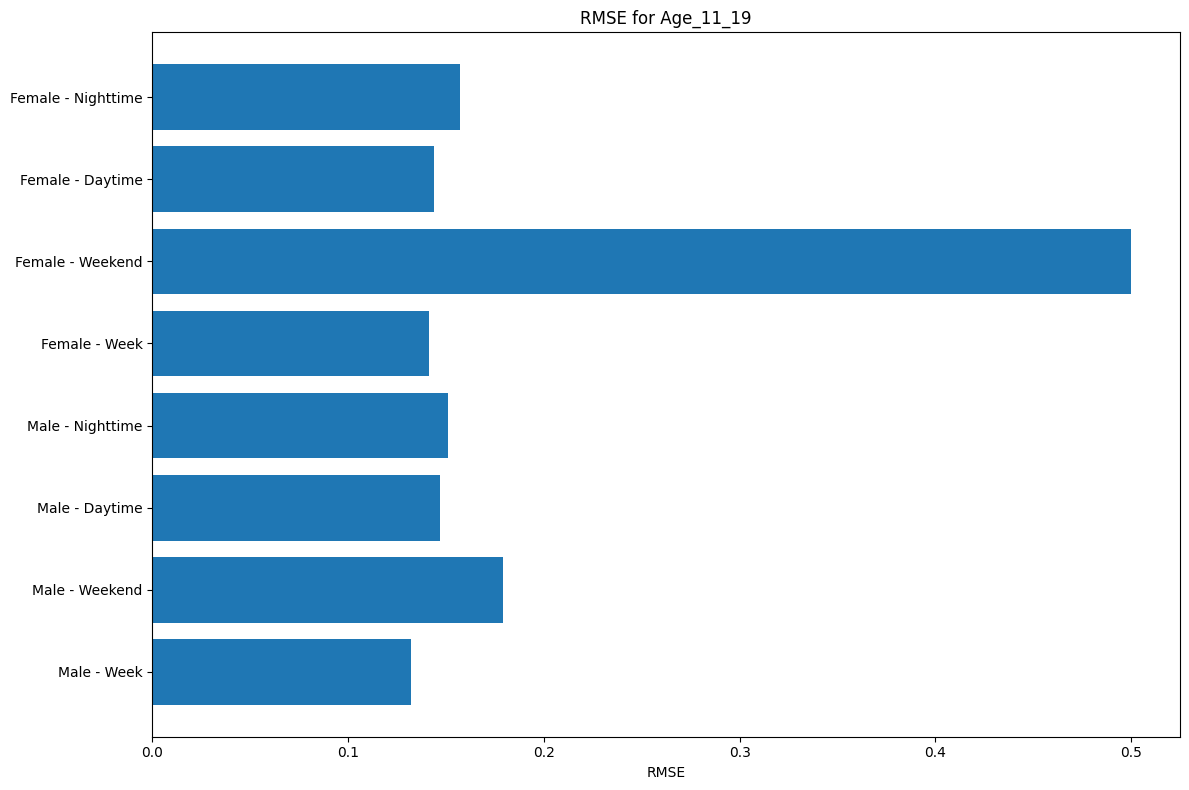

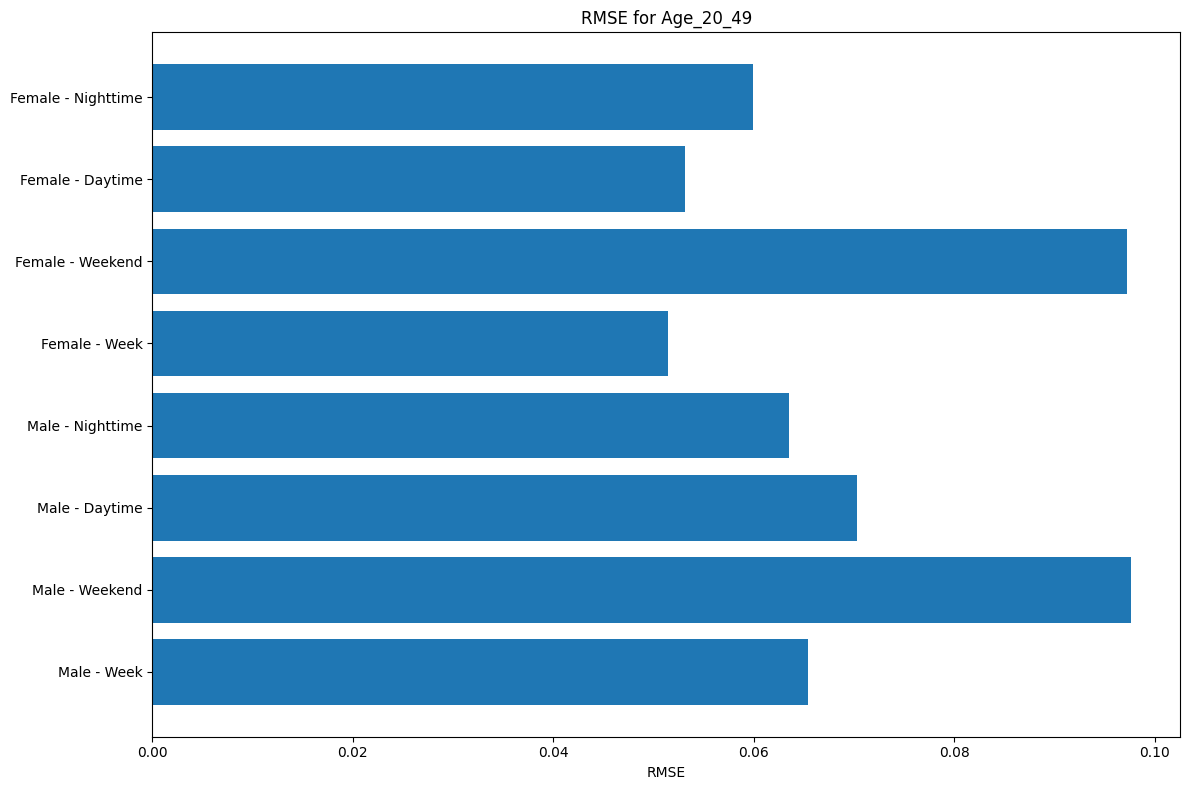

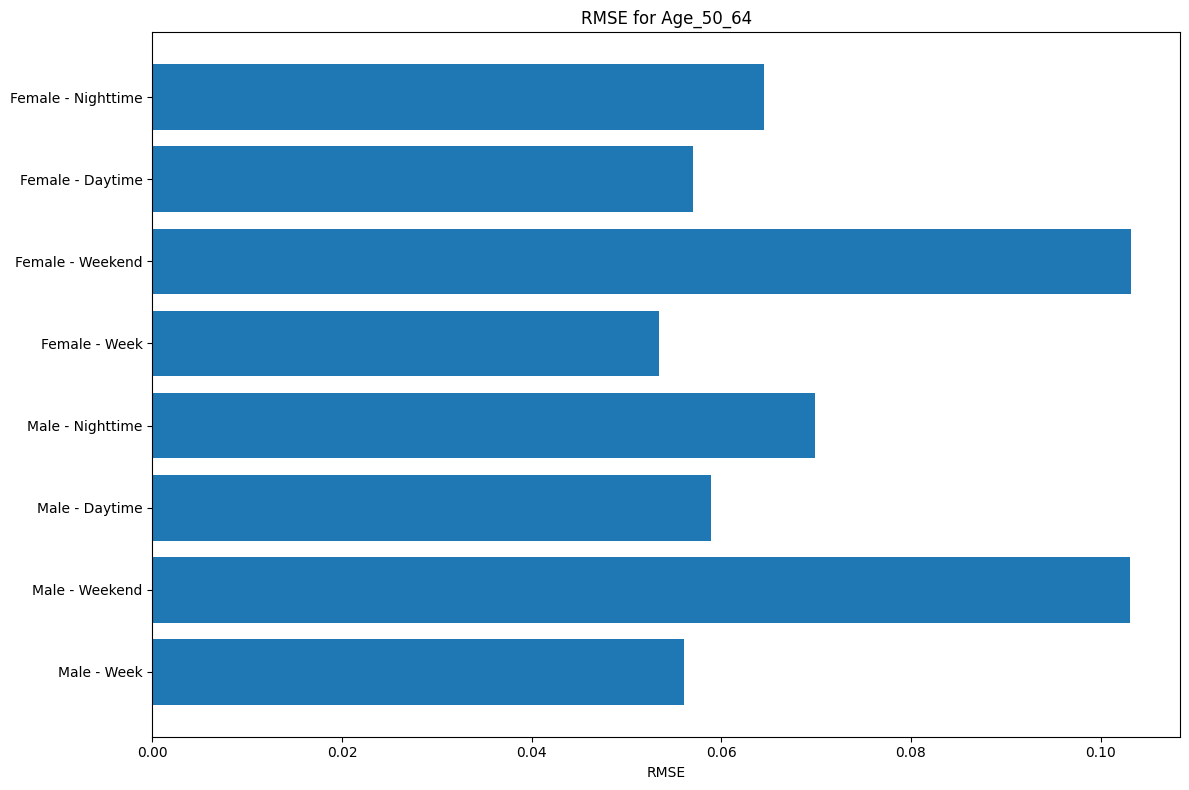

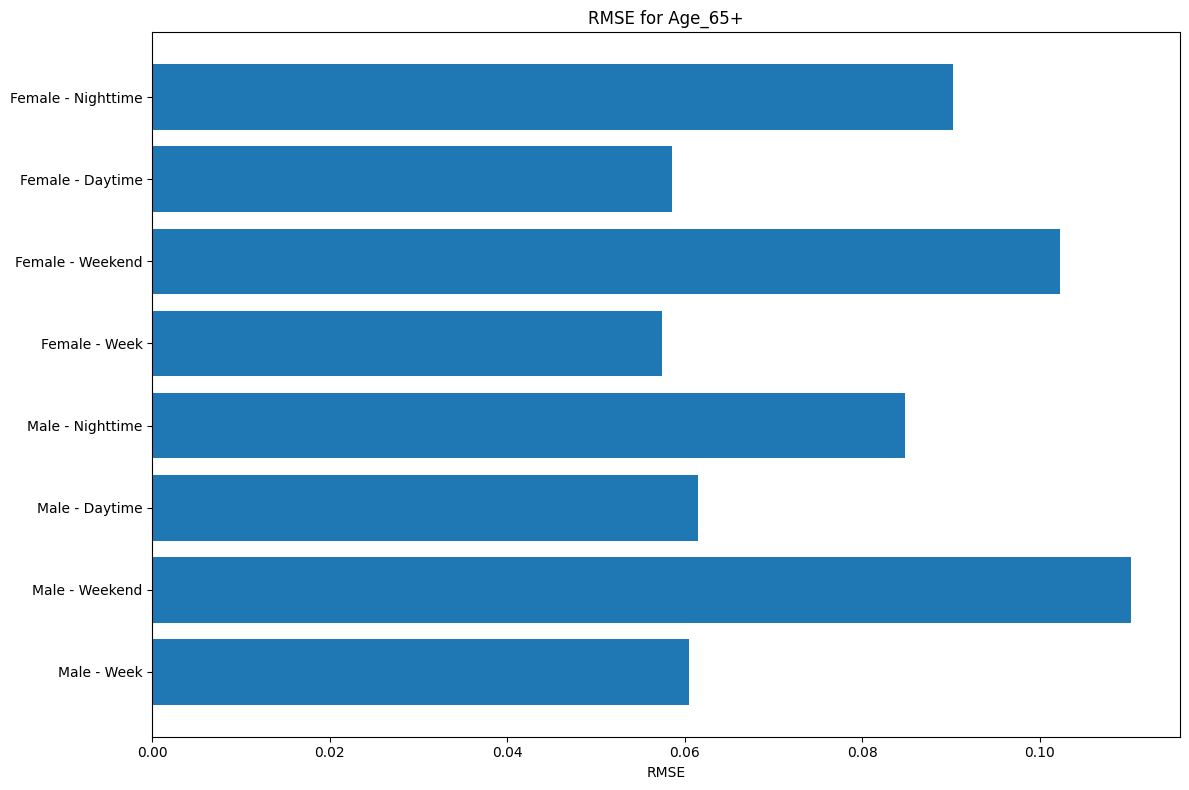

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Helper function to filter data based on conditions
def filter_od_matrix(df, day_filter=None, hour_filter=None):
    if day_filter is not None:
        df = df[df["day"].isin(day_filter)]
    if hour_filter is not None:
        if hour_filter[0] < hour_filter[1]:  # Normal case, e.g., 7:00 to 18:00
            df = df[(df["hour"] >= hour_filter[0]) & (df["hour"] < hour_filter[1])]
        else:  # Overnight case, e.g., 18:00 to 7:00
            df = df[(df["hour"] >= hour_filter[0]) | (df["hour"] < hour_filter[1])]
    return df

# Function to compute OD matrix
def compute_od_matrix(df, origin_col, destination_col):
    od_matrix = df.groupby([origin_col, destination_col]).size().unstack(fill_value=0)
    row_sums = od_matrix.sum(axis=1).replace(0, 1)  # Avoid division by zero
    return od_matrix.div(row_sums, axis=0)

# Function to calculate RMSE similarity
def compute_rmse(matrix_a, matrix_b):
    zones = sorted(set(matrix_a.index).union(set(matrix_b.index)))
    matrix_a = matrix_a.reindex(index=zones, columns=zones, fill_value=0)
    matrix_b = matrix_b.reindex(index=zones, columns=zones, fill_value=0)
    return np.sqrt(np.mean((matrix_a.values - matrix_b.values) ** 2))

# Preprocessing to get IMQ and Unipol data
imq_data, unipol_merged = data_preprocessing()

# Define age and gender groups for both datasets
groups = {
    "Age_11_19": {
        "Male": {
            "imq": imq_data[(imq_data["GENDER"] == 1) & (imq_data["AGE"] == 1)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "M") & (unipol_merged["eta_approx"] >= 11) & (unipol_merged["eta_approx"] <= 19)],
        },
        "Female": {
            "imq": imq_data[(imq_data["GENDER"] == 2) & (imq_data["AGE"] == 1)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "F") & (unipol_merged["eta_approx"] >= 11) & (unipol_merged["eta_approx"] <= 19)],
        },
    },
    "Age_20_49": {
        "Male": {
            "imq": imq_data[(imq_data["GENDER"] == 1) & (imq_data["AGE"] == 2)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "M") & (unipol_merged["eta_approx"] >= 20) & (unipol_merged["eta_approx"] <= 49)],
        },
        "Female": {
            "imq": imq_data[(imq_data["GENDER"] == 2) & (imq_data["AGE"] == 2)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "F") & (unipol_merged["eta_approx"] >= 20) & (unipol_merged["eta_approx"] <= 49)],
        },
    },
    "Age_50_64": {
        "Male": {
            "imq": imq_data[(imq_data["GENDER"] == 1) & (imq_data["AGE"] == 3)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "M") & (unipol_merged["eta_approx"] >= 50) & (unipol_merged["eta_approx"] <= 64)],
        },
        "Female": {
            "imq": imq_data[(imq_data["GENDER"] == 2) & (imq_data["AGE"] == 3)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "F") & (unipol_merged["eta_approx"] >= 50) & (unipol_merged["eta_approx"] <= 64)],
        },
    },
    "Age_65+": {
        "Male": {
            "imq": imq_data[(imq_data["GENDER"] == 1) & (imq_data["AGE"] == 4)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "M") & (unipol_merged["eta_approx"] >= 65)],
        },
        "Female": {
            "imq": imq_data[(imq_data["GENDER"] == 2) & (imq_data["AGE"] == 4)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "F") & (unipol_merged["eta_approx"] >= 65)],
        },
    },
}

# Define conditions
time_filters = {
    "Week": {"day_filter": range(0, 6)},
    "Weekend": {"day_filter": range(6, 8)},
    "Daytime": {"hour_filter": (7, 18)},
    "Nighttime": {"hour_filter": (18, 7)},
}

# Calculate RMSE for all conditions and groups
results = {age_group: [] for age_group in groups.keys()}

for age_group, genders in groups.items():
    for gender, datasets in genders.items():
        for condition, filters in time_filters.items():
            # Filter IMQ and Unipol data
            imq_filtered = filter_od_matrix(datasets["imq"], **filters)
            unipol_filtered = filter_od_matrix(datasets["unipol"], **filters)

            # Compute OD matrices
            imq_od = compute_od_matrix(imq_filtered, "ORI_ZONE", "DST_ZONE")
            unipol_od = compute_od_matrix(unipol_filtered, "ORI_ZONE", "DST_ZONE")

            # Compute RMSE between IMQ and Unipol
            rmse = compute_rmse(imq_od, unipol_od)
            results[age_group].append((f"{gender} - {condition}", rmse))

# Visualize the RMSE values
for age_group, values in results.items():
    labels, rmses = zip(*values)
    plt.figure(figsize=(12, 8))
    plt.barh(labels, rmses)
    plt.xlabel("RMSE")
    plt.title(f"RMSE for {age_group}")
    plt.tight_layout()
    plt.show()


## b. Consider IMQ dataset, what gender of user has greater differences in behaviour across age groups?

UnipolTech Data:
   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop commerciale  eta_approx genere  \
0  2024-08-27 21:16:05    45.069     7.698           N          47      M   
1  2024-08-27 21:32:03    45.083     7.675           N          47      M   
2  2024-08-28 08:29:07    45.067     7.688           N          47      M   
3  2024-08-28 11:54:02    45.083     7.675           N          47      M   
4  2024-08-29 12:31:44    45.077     7.668           N          47      M   

   ORI_ZONE  DST_ZONE  hour  day  
0       7.0       7.0    21    1  
1       7.0      

C:\Users\sartr\AppData\Local\Temp\ipykernel_6948\917964282.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  imq_data["day"] = pd.to_datetime(imq_data["DEP_HOUR"], errors="coerce").dt.dayofweek


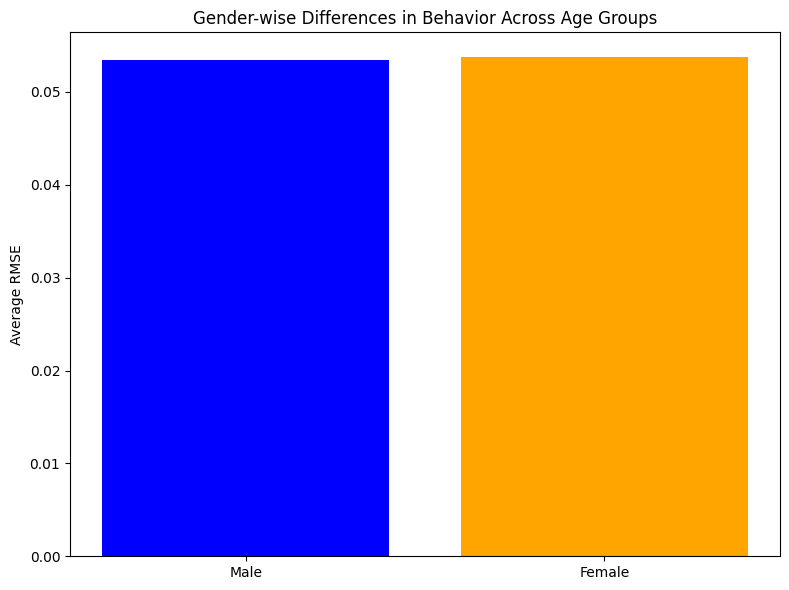

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Helper function to filter data based on conditions
def filter_od_matrix(df, day_filter=None, hour_filter=None):
    if day_filter is not None:
        df = df[df["day"].isin(day_filter)]
    if hour_filter is not None:
        if hour_filter[0] < hour_filter[1]:  # Normal case, e.g., 7:00 to 18:00
            df = df[(df["hour"] >= hour_filter[0]) & (df["hour"] < hour_filter[1])]
        else:  # Overnight case, e.g., 18:00 to 7:00
            df = df[(df["hour"] >= hour_filter[0]) | (df["hour"] < hour_filter[1])]
    return df

# Function to compute OD matrix
def compute_od_matrix(df, origin_col, destination_col):
    od_matrix = df.groupby([origin_col, destination_col]).size().unstack(fill_value=0)
    row_sums = od_matrix.sum(axis=1).replace(0, 1)  # Avoid division by zero
    return od_matrix.div(row_sums, axis=0)

# Function to calculate RMSE similarity
def compute_rmse(matrix_a, matrix_b):
    zones = sorted(set(matrix_a.index).union(set(matrix_b.index)))
    matrix_a = matrix_a.reindex(index=zones, columns=zones, fill_value=0)
    matrix_b = matrix_b.reindex(index=zones, columns=zones, fill_value=0)
    return np.sqrt(np.mean((matrix_a.values - matrix_b.values) ** 2))

# Preprocessing to get IMQ data
imq_data, _ = data_preprocessing()

# Define age groups and genders
gender_groups = {
    "Male": imq_data[imq_data["GENDER"] == 1],
    "Female": imq_data[imq_data["GENDER"] == 2]
}

age_groups = {
    "Age_11_19": 1,
    "Age_20_49": 2,
    "Age_50_64": 3,
    "Age_65+": 4
}

# Compute RMSE for gender differences
rmse_results = {}

for gender, data in gender_groups.items():
    age_matrices = []
    for age_group, age_code in age_groups.items():
        age_data = data[data["AGE"] == age_code]
        od_matrix = compute_od_matrix(age_data, "ORI_ZONE", "DST_ZONE")
        age_matrices.append(od_matrix)

    # Calculate average RMSE across age group matrices
    rmses = []
    for i in range(len(age_matrices)):
        for j in range(i + 1, len(age_matrices)):
            rmses.append(compute_rmse(age_matrices[i], age_matrices[j]))

    rmse_results[gender] = np.mean(rmses) if rmses else np.nan

# Plot the RMSE values
plt.figure(figsize=(8, 6))
plt.bar(rmse_results.keys(), rmse_results.values(), color=['blue', 'orange'])
plt.ylabel("Average RMSE")
plt.title("Gender-wise Differences in Behavior Across Age Groups")
plt.tight_layout()
plt.show()


## Consider IMQ dataset, what kind of users are more likely to use Car2GO and Enjoy?

C:\Users\sartr\AppData\Local\Temp\ipykernel_6948\917964282.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  imq_data["day"] = pd.to_datetime(imq_data["DEP_HOUR"], errors="coerce").dt.dayofweek


UnipolTech Data:
   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop commerciale  eta_approx genere  \
0  2024-08-27 21:16:05    45.069     7.698           N          47      M   
1  2024-08-27 21:32:03    45.083     7.675           N          47      M   
2  2024-08-28 08:29:07    45.067     7.688           N          47      M   
3  2024-08-28 11:54:02    45.083     7.675           N          47      M   
4  2024-08-29 12:31:44    45.077     7.668           N          47      M   

   ORI_ZONE  DST_ZONE  hour  day  
0       7.0       7.0    21    1  
1       7.0      

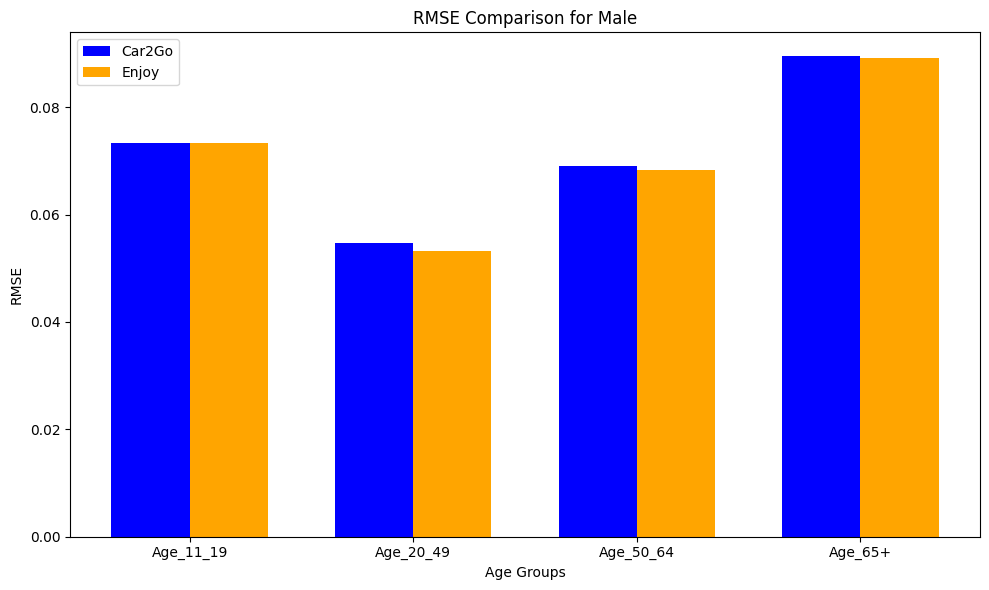

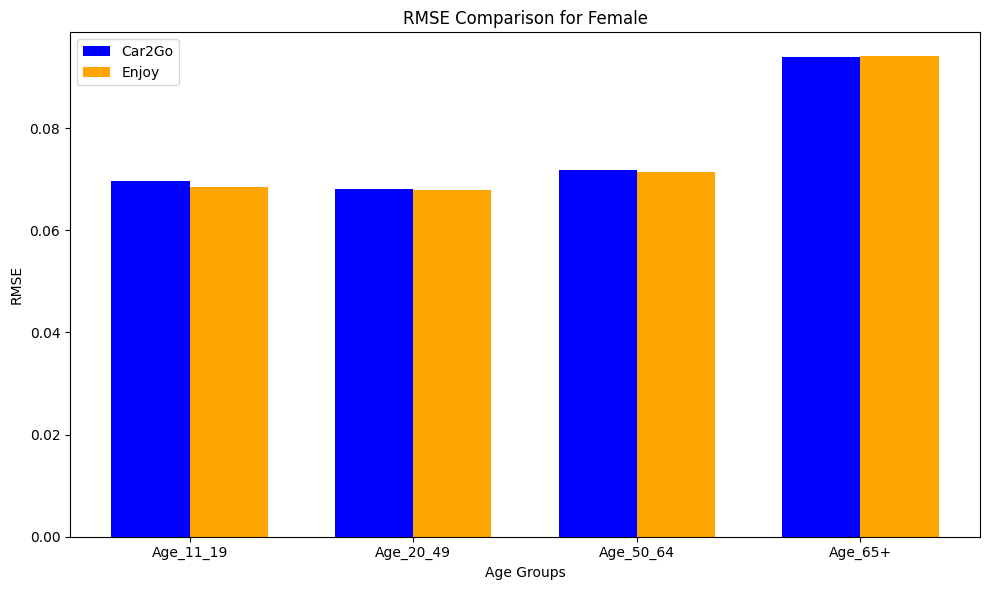

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Helper function to filter data based on conditions
def filter_od_matrix(df, day_filter=None, hour_filter=None):
    if day_filter is not None:
        df = df[df["day"].isin(day_filter)]
    if hour_filter is not None:
        if hour_filter[0] < hour_filter[1]:  # Normal case, e.g., 7:00 to 18:00
            df = df[(df["hour"] >= hour_filter[0]) & (df["hour"] < hour_filter[1])]
        else:  # Overnight case, e.g., 18:00 to 7:00
            df = df[(df["hour"] >= hour_filter[0]) | (df["hour"] < hour_filter[1])]
    return df

# Function to compute OD matrix
def compute_od_matrix(df, origin_col, destination_col):
    od_matrix = df.groupby([origin_col, destination_col]).size().unstack(fill_value=0)
    row_sums = od_matrix.sum(axis=1).replace(0, 1)  # Avoid division by zero
    return od_matrix.div(row_sums, axis=0)

# Function to calculate RMSE similarity
def compute_rmse(matrix_a, matrix_b):
    zones = sorted(set(matrix_a.index).union(set(matrix_b.index)))
    matrix_a = matrix_a.reindex(index=zones, columns=zones, fill_value=0)
    matrix_b = matrix_b.reindex(index=zones, columns=zones, fill_value=0)
    return np.sqrt(np.mean((matrix_a.values - matrix_b.values) ** 2))

# Preprocessing to get IMQ data
imq_data, _ = data_preprocessing()

# Load Car2Go and Enjoy OD matrices
car2go_od_matrix = pd.read_csv("car2go_od_matrix.csv")
enjoy_od_matrix = pd.read_csv("enjoy_od_matrix.csv")

car2go_od_global = compute_od_matrix(car2go_od_matrix, "ORI_ZONE", "DST_ZONE")
enjoy_od_global = compute_od_matrix(enjoy_od_matrix, "ORI_ZONE", "DST_ZONE")

# Define age groups and genders
gender_groups = {
    "Male": imq_data[imq_data["GENDER"] == 1],
    "Female": imq_data[imq_data["GENDER"] == 2]
}

age_groups = {
    "Age_11_19": 1,
    "Age_20_49": 2,
    "Age_50_64": 3,
    "Age_65+": 4
}

# Compute RMSE for IMQ groups against Car2Go and Enjoy
rmse_results = {"Male": [], "Female": []}

for gender, data in gender_groups.items():
    for age_group, age_code in age_groups.items():
        age_data = data[data["AGE"] == age_code]
        imq_od_global = compute_od_matrix(age_data, "ORI_ZONE", "DST_ZONE")

        rmse_car2go = compute_rmse(imq_od_global, car2go_od_global)
        rmse_enjoy = compute_rmse(imq_od_global, enjoy_od_global)

        rmse_results[gender].append((age_group, rmse_car2go, rmse_enjoy))

# Plot the RMSE values
for gender, values in rmse_results.items():
    age_groups, rmse_car2go, rmse_enjoy = zip(*values)

    x = np.arange(len(age_groups))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, rmse_car2go, width, label="Car2Go", color="blue")
    plt.bar(x + width/2, rmse_enjoy, width, label="Enjoy", color="orange")

    plt.xlabel("Age Groups")
    plt.ylabel("RMSE")
    plt.title(f"RMSE Comparison for {gender}")
    plt.xticks(x, age_groups)
    plt.legend()
    plt.tight_layout()
    plt.show()


## 3. d Compare OD matrices overall

C:\Users\sartr\AppData\Local\Temp\ipykernel_6948\917964282.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  imq_data["day"] = pd.to_datetime(imq_data["DEP_HOUR"], errors="coerce").dt.dayofweek


UnipolTech Data:
   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop commerciale  eta_approx genere  \
0  2024-08-27 21:16:05    45.069     7.698           N          47      M   
1  2024-08-27 21:32:03    45.083     7.675           N          47      M   
2  2024-08-28 08:29:07    45.067     7.688           N          47      M   
3  2024-08-28 11:54:02    45.083     7.675           N          47      M   
4  2024-08-29 12:31:44    45.077     7.668           N          47      M   

   ORI_ZONE  DST_ZONE  hour  day  
0       7.0       7.0    21    1  
1       7.0      

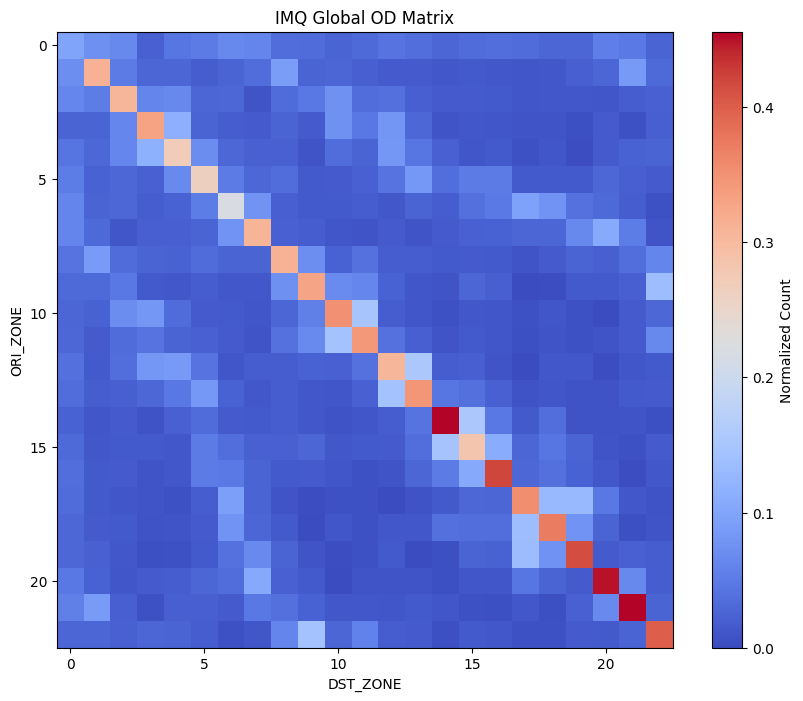

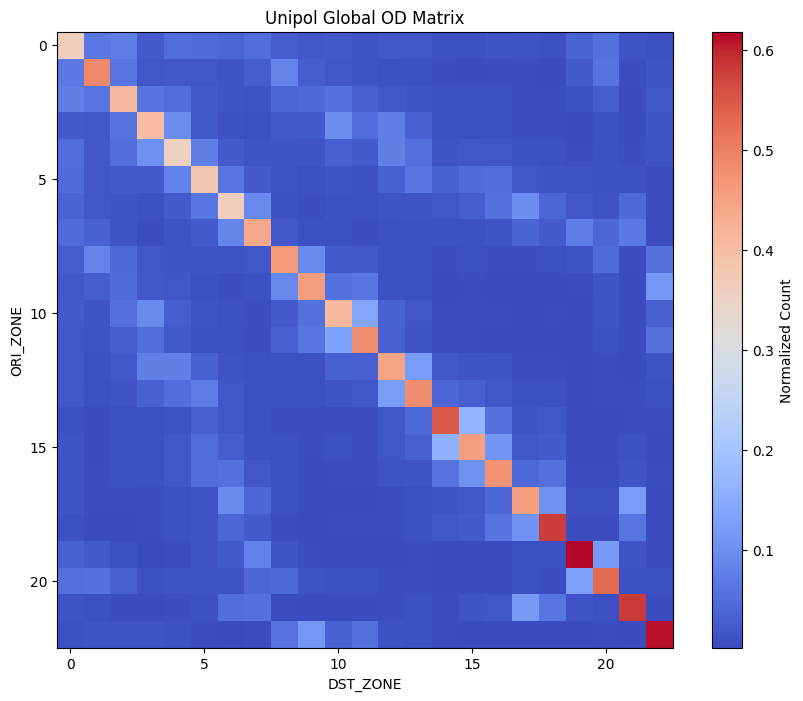

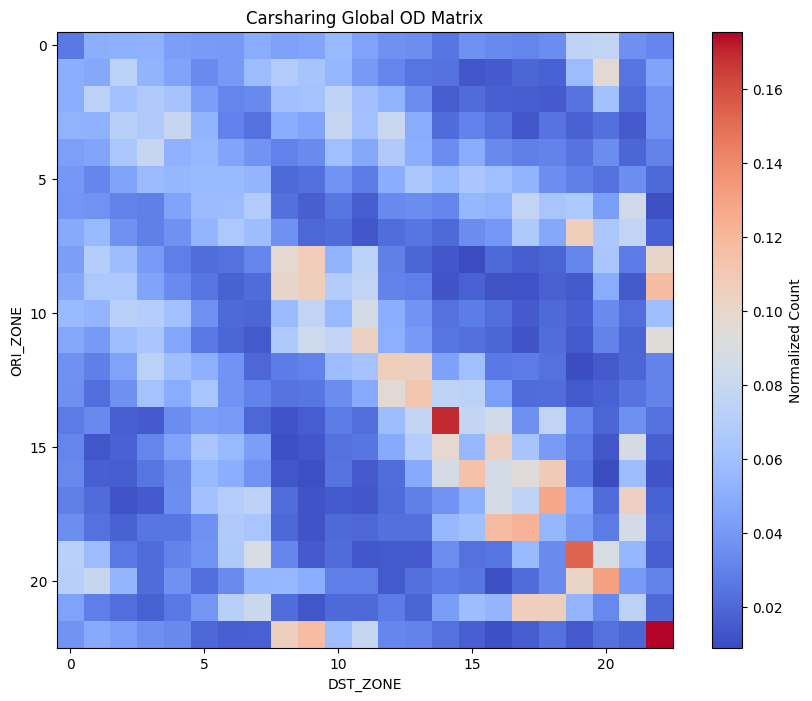

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Helper function to normalize OD matrix bidirectionally
def normalize_od_matrix_bidirectional(df):
    pivot = df.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="count", fill_value=0)

    for _ in range(10):
        # Normalize rows
        row_sums = pivot.sum(axis=1)
        pivot = pivot.div(row_sums, axis=0).fillna(0)

        # Normalize columns
        col_sums = pivot.sum(axis=0)
        pivot = pivot.div(col_sums, axis=1).fillna(0)

    return pivot.stack().reset_index(name="normalized_count")

# Function to adjust zones to start from 0
def adjust_zones(df):
    df["ORI_ZONE"] = df["ORI_ZONE"] - 1
    df["DST_ZONE"] = df["DST_ZONE"] - 1
    return df

# Function to compute normalized OD matrix
# Count trips between zones directly in this function
def compute_normalized_od_matrix(df, origin_col, destination_col):
    # Count trips explicitly between each origin and destination
    trip_counts = df.groupby([origin_col, destination_col]).size().reset_index(name="count")
    
    # Normalize the OD matrix bidirectionally
    normalized_matrix = normalize_od_matrix_bidirectional(trip_counts)
    
    # Pivot the matrix for visualization
    return normalized_matrix.pivot(index="ORI_ZONE", columns="DST_ZONE", values="normalized_count").fillna(0)


# Preprocessing to get IMQ data
imq_data, unipol_merged = data_preprocessing()

# Adjust zones to start from 0
imq_data = adjust_zones(imq_data)
unipol_merged = adjust_zones(unipol_merged)

# Load Car2Go and Enjoy OD data
car2go_reader = pd.read_csv("car2go_od_matrix.csv", chunksize=10000)
enjoy_reader = pd.read_csv("enjoy_od_matrix.csv", chunksize=10000)

car2go_data = pd.concat([chunk for chunk in car2go_reader], ignore_index=True)
enjoy_data = pd.concat([chunk for chunk in enjoy_reader], ignore_index=True)

car2go_data = adjust_zones(car2go_data)
enjoy_data = adjust_zones(enjoy_data)

# Combine Car2Go and Enjoy into Carsharing data
carsharing_data = pd.concat([car2go_data, enjoy_data], ignore_index=True)

# Compute global normalized OD matrices
imq_od_global = compute_normalized_od_matrix(imq_data, "ORI_ZONE", "DST_ZONE")
unipol_od_global = compute_normalized_od_matrix(unipol_merged, "ORI_ZONE", "DST_ZONE")
carsharing_od_global = compute_normalized_od_matrix(carsharing_data, "ORI_ZONE", "DST_ZONE")

# Plot the global OD matrices
plt.figure(figsize=(10, 8))
plt.imshow(imq_od_global, cmap="coolwarm", interpolation="nearest")
plt.title("IMQ Global OD Matrix")
plt.colorbar(label="Normalized Count")
plt.xlabel("DST_ZONE")
plt.ylabel("ORI_ZONE")
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(unipol_od_global, cmap="coolwarm", interpolation="nearest")
plt.title("Unipol Global OD Matrix")
plt.colorbar(label="Normalized Count")
plt.xlabel("DST_ZONE")
plt.ylabel("ORI_ZONE")
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(carsharing_od_global, cmap="coolwarm", interpolation="nearest")
plt.title("Carsharing Global OD Matrix")
plt.colorbar(label="Normalized Count")
plt.xlabel("DST_ZONE")
plt.ylabel("ORI_ZONE")
plt.show()
